# Test annotated data

In [4]:
import json
import sys
if('..' not in sys.path):
    sys.path.append('..')
from lqam.methods.dataset import URL_DATA_VAL
import requests
print(URL_DATA_VAL)
annotated_data = json.loads(requests.get(URL_DATA_VAL).text)

https://drive.google.com/uc?id=1rglAizpxanVDejDP6HuCM7UaXLxEQwnK&export=download


In [5]:
print(json.dumps(annotated_data[10]))

{"video_id": "b72mXcSFozc", "video_start_time": 41, "video_end_time": 51, "caption": "An old man is outside hammering nails into a stone block.", "masked_caption": "An old man is outside hammering nails into _____.", "label": "a stone block", "additional_answers": [["a piece of granite", "a slab of granite", "a long chunk of granite"], ["cement", "rock", "a boulder", "stone", "granite"], ["cement", "concrete", "a line"], ["concrete", "cement"], ["granite", "stone"]]}


In [32]:
## normalize all data
import sys
if('..' not in sys.path):
    sys.path.append('..')
from lqam.core.metrics import normalize_answer
for data_i in annotated_data:
    data_i['label_norm'] = normalize_answer(data_i['label'])
    data_i['annotations_norm'] = [[normalize_answer(y) for y in x] for x in data_i['additional_answers']]

## Noun distribution
Let's look at the top-K nouns for (1) ground-truth data and (2) labeled data.

In [30]:
import pandas as pd
ground_truth_labels = list(map(lambda x: x['label_norm'].lower(), annotated_data))
ground_truth_label_counts = pd.Series(ground_truth_labels).value_counts()
display(ground_truth_label_counts.head(20))

man          49
person       27
it           23
woman        21
people       13
them         12
front        10
he           10
group        10
someone      10
young man     8
boy           8
piece         7
girl          7
camera        7
child         6
baby          6
table         6
water         6
music         5
dtype: int64

In [33]:
from functools import reduce
annotation_labels = []
for annotated_data_i in annotated_data:
    for annotations_j in annotated_data_i['annotations_norm']:
        clean_annotations_j = list(map(lambda x: x.lower(), annotations_j))
        annotation_labels.extend(clean_annotations_j)
annotation_label_counts = pd.Series(annotation_labels).value_counts()
display(annotation_label_counts.head(20))

man        508
person     442
woman      242
guy        190
boy        176
people     161
girl       154
child      147
someone    133
kid        130
group      127
lady       112
baby        95
kids        89
camera      72
water       70
music       68
it          68
ball        67
boys        66
dtype: int64

### Nouns with low/high agreement
Which nouns have lower or higher agreement?

We'll measure agreement with exact overlap to start, and then partial overlap if we need more data.

In [8]:
from lqam.core.metrics import normalize_answer, tokenize_answer_to_compute_metrics, compute_token_level_f1_many
def compute_overlap_score(label, annotations):
    label_tokens = tokenize_answer_to_compute_metrics(normalize_answer(label))
    annotation_tokens = list(map(lambda x: list(map(lambda y: tokenize_answer_to_compute_metrics(normalize_answer(y)), x)), annotations))
    # flatten token lists
    annotation_tokens = [y for x in annotation_tokens for y in x]
    overlap_score = compute_token_level_f1_many(label_tokens, annotation_tokens)
    return overlap_score

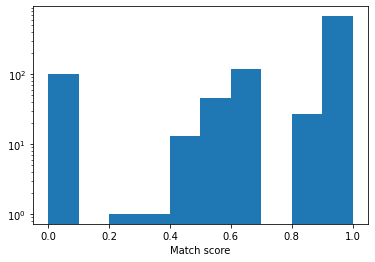

In [34]:
# show distribution first
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
valid_annotated_data = list(filter(lambda x: len(x['additional_answers']) > 0, annotated_data))
overlap_scores = list(map(lambda x: compute_overlap_score(x['label_norm'], x['annotations_norm']), valid_annotated_data))
plt.hist(overlap_scores)
plt.xlabel("Match score")
plt.yscale('log')
plt.show()

In [35]:
import numpy as np
print(f'{(np.array(overlap_scores) == 1.0).sum() / len(overlap_scores)*100}% of captions with at least one complete overlap')

68.62944162436548% of captions with at least one complete overlap


Most questions have fairly low rate of exact matches, which may be unusually low for questions with higher number of annotations provided.

In [36]:
## compute average overlap per NP
valid_annotated_data_labels = list(map(lambda x: x['label_norm'], valid_annotated_data))
label_annotation_overlap = pd.DataFrame(list(zip(valid_annotated_data_labels, overlap_scores)), columns=['label', 'overlap_score'])
label_annotation_overlap_aggregate = label_annotation_overlap.groupby('label').apply(lambda x: x.loc[:, 'overlap_score'].mean())
label_annotation_overlap_aggregate.sort_values(inplace=True, ascending=False)
print('ground-truth labels with highest annotation overlap')
display(label_annotation_overlap_aggregate.head(20))
label_annotation_overlap_aggregate.sort_values(inplace=True, ascending=True)
print('ground-truth labels with lowest annotation overlap')
display(label_annotation_overlap_aggregate.head(20))

ground-truth labels with highest annotation overlap


label
melody           1.0
knife            1.0
ink              1.0
bicycle chain    1.0
instruments      1.0
jar              1.0
bench            1.0
jump kick        1.0
keyboard         1.0
kid              1.0
kids             1.0
kitchen          1.0
kite             1.0
knives           1.0
ice skater       1.0
knuckles         1.0
lab coat         1.0
ladder           1.0
ladies           1.0
lady             1.0
dtype: float64

ground-truth labels with lowest annotation overlap


label
about nine game pieces       0.0
anvil                        0.0
studio                       0.0
swirl                        0.0
taekwondo                    0.0
themselves                   0.0
time                         0.0
timelapse                    0.0
another item                 0.0
twos                         0.0
very small do                0.0
voices                       0.0
wind                         0.0
adult female                 0.0
women                        0.0
press                        0.0
strand                       0.0
cameraman                    0.0
some swimming exhibitions    0.0
puppy                        0.0
dtype: float64

The words with higher agreement tend to be simple and concrete nouns (`keyboard`, `knife`).

The words with lower agreement tend to be highly specific (`about nine game pieces`, `cameraman`) or vague (`another item`, `swirl`).

## Tokens per NP
How many tokens on average does each noun phrase contain?

We'll look at this for both ground-truth and annotations.

gold label NPs have 1.469 +/- 0.686 tokens
annotation NPs have 1.369 +/- 0.686 tokens


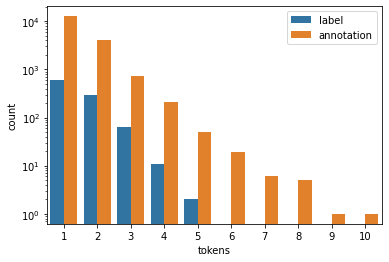

In [38]:
from nltk.tokenize import WordPunctTokenizer
import numpy as np
tokenizer = WordPunctTokenizer()
label_token_counts = list(map(lambda x: len(tokenizer.tokenize(x)), valid_annotated_data_labels))
flat_annotation_labels = [z for x in valid_annotated_data for y in x['annotations_norm'] for z in y]
# remove null labels?
flat_annotation_labels = list(filter(lambda x: len(x) > 0, flat_annotation_labels))
annotation_label_token_counts = [len(tokenizer.tokenize(x)) for x in flat_annotation_labels]
print('gold label NPs have %.3f +/- %.3f tokens'%(np.mean(label_token_counts), np.std(label_token_counts)))
print('annotation NPs have %.3f +/- %.3f tokens'%(np.mean(annotation_label_token_counts), np.std(annotation_label_token_counts)))
## get combined counts => show as bar chart
label_token_count_bins = pd.Series(label_token_counts).value_counts().reset_index().assign(**{'data_type' : 'label'})
annotation_label_token_count_bins = pd.Series(annotation_label_token_counts).value_counts().reset_index().assign(**{'data_type' : 'annotation'})
combined_token_count_bins = pd.concat([
    label_token_count_bins,
    annotation_label_token_count_bins,
]).rename(columns={'index' : 'tokens', 0 : 'count'})
import seaborn as sns
sns.barplot(y='count', x='tokens', data=combined_token_count_bins, hue='data_type')
plt.legend(loc='upper right')
plt.yscale('log')
plt.show()

The gold labels tend to be slightly longer, and annotation labels are more central-skewed (2 words or below) vs. the long tail of tokens in the gold labels.

What are the longest/shortest labels in each set?

In [39]:
label_token_count_data = pd.Series(label_token_counts, index=list(map(lambda x: x.lower(), valid_annotated_data_labels))).sort_values(inplace=False, ascending=False)
flat_annotation_label_token_count_data = pd.Series(annotation_label_token_counts, index=list(map(lambda x: x.lower(), flat_annotation_labels))).sort_values(inplace=False, ascending=False)
label_token_count_data = label_token_count_data[~label_token_count_data.index.duplicated()]
flat_annotation_label_token_count_data = flat_annotation_label_token_count_data[~flat_annotation_label_token_count_data.index.duplicated()]
print('longest gold label NPs')
display(label_token_count_data.head(20))
print('longest annotation NPs')
display(flat_annotation_label_token_count_data.head(20))

longest gold label NPs


innocent cute little baby boy    5
black and white knitting kit     5
very well built woman            4
complex stretching yoga pose     4
her very colorful leggings       4
ornately costumed dance squad    4
about nine game pieces           4
strung out teenage girls         4
his rock climbing equipment      4
large multiple dig site          4
his toy train set                4
human ping pong ball             4
basic photo copy machine         4
different gear shifts            3
automatic teller machine         3
two little boys                  3
beat making machine              3
her overstressed tanktop         3
small motorized carts            3
two young boys                   3
dtype: int64

longest annotation NPs


2 teams one in yellow jerseys and one white jerseys    10
poor animal who needs its wool to stay warm             9
2 people total and 1 in full view                       8
cowboy wearing blue jeans and blue jean jacket          8
male wearing shoes and black pants with stripes         8
boy in black and boy in blue tshirt                     8
2 young kids with shorts and no shirts                  8
girl in tshirt and bathing suit bottom                  7
shirtless man with black bottom bathing suit            7
2 males wearing blue shirt and shorts                   7
kid in black shirt and black pants                      7
while sitting and using fork to eat                     7
man in white shirt and black pants                      7
street in front of house driveway                       6
2 teams wearing jerseys and helmets                     6
man with small amounts of hair                          6
front of green curtain and front                        6
numerous track

The longest NPs for the gold labels tend to have multiple adjectives (`an innocent cute little baby boy`) and possessive markers (`a man's back`).

The longest NPs for the annotation labels tend to have coordination (`a man in shorts and black t-shirt`) and long, unnecessary subclauses (`the poor animal who needs it's wool to stay warm`).

### Unique NPs per question
How many unique NPs does each question get?

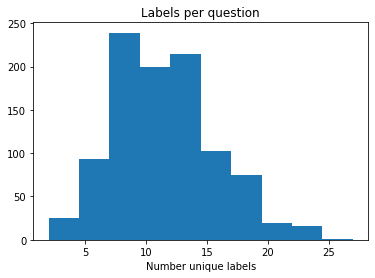

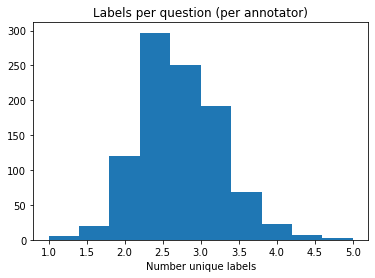

questions have an average of 11.292 +/- 4.126 unique labels
annotators have an average of 2.704 +/- 0.534 unique labels


In [40]:
def get_num_unique_labels_per_annotator(data):
    ## TODO: only include first label from each annotator? some annotators may have included extra words just for bonus
    data_annotation_label_sets = [set([y.lower() for y in x]) for x in data['annotations_norm']]
    num_unique_data_annotation_labels = list(map(lambda x: len(x), data_annotation_label_sets))
    mean_unique_data_annotation_labels = np.mean(num_unique_data_annotation_labels)
    return mean_unique_data_annotation_labels
unique_labels_per_question = list(map(lambda x: list(sorted(set([z.lower() for y in x['annotations_norm'] for z in y]))), valid_annotated_data))
num_unique_labels_per_question = list(map(lambda x: len(x), unique_labels_per_question))
num_unique_labels_per_question_per_annotator = list(map(lambda x: get_num_unique_labels_per_annotator(x), valid_annotated_data))
plt.hist(num_unique_labels_per_question)
plt.xlabel('Number unique labels')
plt.title('Labels per question')
plt.show()
plt.hist(num_unique_labels_per_question_per_annotator)
plt.xlabel('Number unique labels')
plt.title('Labels per question (per annotator)')
plt.show()
print('questions have an average of %.3f +/- %.3f unique labels'%(np.mean(num_unique_labels_per_question), np.std(num_unique_labels_per_question)))
print('annotators have an average of %.3f +/- %.3f unique labels'%(np.mean(num_unique_labels_per_question_per_annotator), np.std(num_unique_labels_per_question_per_annotator)))

Most questions have around 11 unique labels total and 3 unique labels per annotator.

Which questions have the most unique labels per annotator?

In [41]:
pd.set_option('display.max_colwidth', 200)
question_prompts = list(map(lambda x: x['masked_caption'], valid_annotated_data))

unique_labels_per_question_per_annotator_data = pd.DataFrame([
    question_prompts,
    num_unique_labels_per_question_per_annotator,
    unique_labels_per_question,
], index=['prompt', 'unique_label_count', 'unique_labels']).transpose()
unique_labels_per_question_per_annotator_data.sort_values('unique_label_count', inplace=True, ascending=False)
print('questions with highest number unique labels per annotator')
display(unique_labels_per_question_per_annotator_data.head(10))
print('questions with lowest number unique labels per annotator')
display(unique_labels_per_question_per_annotator_data.tail(10))

questions with highest number unique labels per annotator


,prompt,unique_label_count,unique_labels
278,_____ lifts a heavy weight from the ground up.,5,"[athlete, body builder, bodybuilder, female, female athlete, female body builder, female bodybuilder, gal, girl, lady, small lady, small woman, tiny lady, weight lifter, woman]"
905,A group of drivers race cars on _____ in front of onlookers.,4.8,"[circuit, clay, course, dirt, dirt path, dirt track, dry sand, field, ground, mud, race grounds, racetrack, raceway, sand, speedway, stretch, track]"
260,A man is walking by _____ that is completely full then comes back and smashes the computer monitor sitting on top with a baseball bat.,4.71429,"[alley, bin, black bin, black bin with garbage, black garbage bin, black rubbish bin, black trash can, black trashcan, dumpster, garbage bin, garbage can, garbage receptacle, grey garbage can, pla..."
427,A group of _____ in pink tutus dancing in a circle on stage.,4.42857,"[arminarm girls, balet students, ballerinas, children, dancers, girls, kids, little girls, little kids, students, toddlers, young ballerinas, young dancers, young girls]"
45,A woman works with _____ at a spinning potter's wheel.,4.42857,"[bowl, boys, boys and girls, class, clay, ease, focus, girls, her children, her class, her family, her hands, her kids, her students, kids, lady, mud, piece of pottery, potter, pottery, skill, stu..."
831,_____ uses several smaller containers to efficiently pack a suitcase while music plays.,4.33333,"[chick, female, girl, lady, lass, person, someone, traveler, woman, young lady]"
835,_____ was picking berries from a bush outside on a sunny day.,4.33333,"[adult and child, duo, family, folks, girl, mother and daughter, people, person, woman, woman and girl, young lady and old lady]"
936,_____ kicks soccer balls into a net while on a grass field.,4.33333,"[adolescent, athlete, boy, child, guy, human, kid, male, my daughters friend, our neighbor, person, player, players, soccer player, someone, son, team member, teams captain, young boy, youth]"
576,_____ plays an instrument while wearing a pink shirt.,4.2,"[artist, bald man, entertainer, guy, individual, man, musician, old man, older man, performer, person, saxophone player, saxophonist, singer, someone]"
749,A man standing in front of a microphone playing some kind of _____.,4.2,"[flute, harmonicalike instrument, instrument, music, musical instrument, noise, pan flute, pan flute music, panflute, pipe, song, tool, unknown instrument, wood instrument, wooden instrument, wood..."


questions with lowest number unique labels per annotator


,prompt,unique_label_count,unique_labels
645,A man demonstrates how to install _____.,1.66667,"[bicycle chain, bike chain, chain, cycle chain, master link, new bike chain, new chain links, piece of equipement]"
863,The man in _____ checks and trims the toenails of a small animal.,1.625,"[black pants, black sweater, chair, clip, knit shirt, sweater, vets office, video, warm sweater]"
613,Two person one standing on _____ and the other doing a cock wheel.,1.6,"[circle, floor, groung, his head, their head, top of his head]"
468,A man juggles balls one-handed and then two-handed and tosses them to a person off-_____.,1.5,"[balance, camera, frame, shot]"
306,A toddler boy is feeding _____ spaghetti at the dinner table.,1.5,"[forkfuls of, himself, his belly, his mouth, while sitting and using fork to eat]"
720,A young boy who seems to be timing _____ how fast he can eat a snack.,1.33333,"[challenge of, himself, his self, recording of, to calculate, to see]"
747,"A man, outdoors at a gas station, is demonstrating step-by-_____, how to pump gas.",1.33333,"[step, way]"
214,"Two teams play football, and the team in _____ completes a pass.",1.33333,"[left, offense, red jerseys, red shirts]"
705,Packages of paper are being wrapped in paper plastic and stacked on _____ of each other.,1.25,"[device next, machine, top]"
847,A person is showing how _____ open a beer with a screw driver indoors.,1,"[he, people, to screw open, you]"


Questions with higher number of unique labels seem to inspire creative answers (`a group of ____ in pink tutus` => different paraphrases for `child`) and address multiple possible aspects of an event due to ambiguity (`a woman works with ____` => "with" applies to other `AGENT` nouns and `INSTRUMENT` nouns).

Questions with lower number of unique labels seem to have very specific scenarios without room for paraphrasing or ambiguity (`to a person off-____` => the blank can only be "camera").

### Assessing visual cues
Some nouns and adjectives have more obvious visual cues than others, ex. "green" has clear visual component whereas "kind" is more subjective.

Let's look for these visual cues in the labels and annotations using some word lists:
- color
- size
- number

In [43]:
## TODO: expand word sets using word embeddings (nearest neighbors + filtering)
color_words = {
    'red', 'blue', 'green', 'yellow', 'purple', 'orange', 'black', 'white', 'gray', 'grey',
    'colorful', 'painted',
}
size_words = {
    'large', 'huge', 'giant', 'small', 'little', 'tiny',
}
number_words = {
    'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten',
    'several', 'few', 'many',
}
visual_word_sets = [
    color_words, size_words, number_words,
]
visual_word_set_names = [
    'color', 'size', 'number',
]

In [44]:
import sys
if('..' not in sys.path):
    sys.path.append('..')
from lqam.core.metrics import tokenize_answer_to_compute_metrics
## tokenize everything
label_tokens = list(map(lambda x: tokenize_answer_to_compute_metrics(x['label_norm']), annotated_data))
annotation_label_tokens = [[tokenize_answer_to_compute_metrics(z) for z in y] for x in valid_annotated_data for y in x['annotations_norm']]

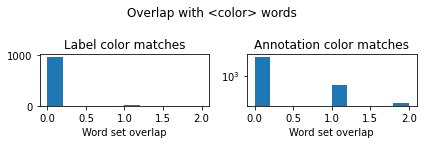

proportion of <color> word matches for labels:
   word_count  label_word_match_pct  annotation_word_match_pct
0           0              0.984802                   0.986248
1           1              0.014184                   0.012910
2           2              0.001013                   0.000842


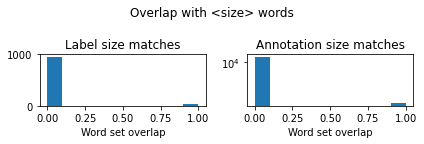

proportion of <size> word matches for labels:
   word_count  label_word_match_pct  annotation_word_match_pct
0           0              0.969605                   0.991636
1           1              0.030395                   0.008364


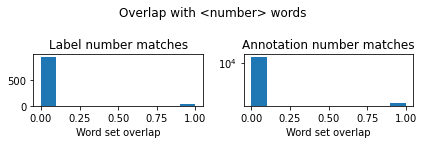

proportion of <number> word matches for labels:
   word_count  label_word_match_pct  annotation_word_match_pct
0           0              0.963526                   0.986191
1           1              0.036474                   0.013809


In [45]:
## get counts, plot distribution of visual words
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
for visual_word_set, visual_word_set_name in zip(visual_word_sets, visual_word_set_names):
    label_word_matches = list(map(lambda x: set(x) & visual_word_set, label_tokens))
    annotation_label_word_matches = [set(y) & visual_word_set for x in annotation_label_tokens for y in x]
    num_label_word_matches = list(map(lambda x: len(x), label_word_matches))
    num_annotation_label_word_matches = list(map(lambda x: len(x), annotation_label_word_matches))
    f, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 2))
    axs[0].hist(num_label_word_matches)
    axs[1].hist(num_annotation_label_word_matches)
    axs[0].set_title(f'Label {visual_word_set_name} matches')
    axs[1].set_title(f'Annotation {visual_word_set_name} matches')
    axs[0].set_xlabel('Word set overlap')
    axs[1].set_xlabel('Word set overlap')
    plt.suptitle(f'Overlap with <{visual_word_set_name}> words')
    plt.yscale('log')
    plt.tight_layout()
    plt.show()
    # compute proportion of visual words per question
    pct_label_word_matches = pd.Series(num_label_word_matches).value_counts() / len(num_label_word_matches)
    pct_annotation_label_word_matches = pd.Series(num_annotation_label_word_matches).value_counts() / len(num_annotation_label_word_matches)
    pct_word_matches = pd.concat([pct_label_word_matches, pct_annotation_label_word_matches], axis=1).reset_index()
    pct_word_matches.columns = ['word_count', 'label_word_match_pct', 'annotation_word_match_pct']
#     pct_word_matches.columns = ['label_match_pct', 'annotation_label_match_pct']
    print(f'proportion of <{visual_word_set_name}> word matches for labels:\n{pct_word_matches}')

Overall, the annotations tend to have about the rate of color words as the labels, but the annotations also have fewer size and number words than the labels.

What are some example questions where the label contains a visual word but the annotations do not?

In [46]:
## get aligned/valid data
valid_label_tokens = list(map(lambda x: tokenize_answer_to_compute_metrics(x['label_norm']), valid_annotated_data))
valid_annotation_label_tokens = [[tokenize_answer_to_compute_metrics(z) for y in x['annotations_norm'] for z in y] for x in valid_annotated_data]
# flatten tokens
valid_annotation_label_tokens = [[z for y in x for z in y] for x in valid_annotation_label_tokens]
sample_size = 10
for visual_word_set, visual_word_set_name in zip(visual_word_sets, visual_word_set_names):
    print(f'*~*~*~* testing word set {visual_word_set_name} *~*~*~*')
    label_word_matches = list(map(lambda x: set(x) & visual_word_set, valid_label_tokens))
    annotation_label_word_matches = list(map(lambda x: set(x) & visual_word_set, valid_annotation_label_tokens))
    sample_ctr = 0
    for data_i, label_word_matches_i, annotation_label_word_matches_i in zip(valid_annotated_data, label_word_matches, annotation_label_word_matches):
        if(len(label_word_matches_i) > 0 and len(annotation_label_word_matches_i) == 0):
            print(f'caption=<{data_i["caption"]}>')
            print(f'label=<{data_i["label"]}> has matches <{label_word_matches_i}>')
            print(f'annotations do not have matches: <{data_i["additional_answers"]}>')
            print('---------')
            sample_ctr += 1
            if(sample_ctr >= sample_size):
                break

*~*~*~* testing word set color *~*~*~*
caption=<A red hot piece of bent steel is being formed with a metal sledge hammer on the end of a  steel table.>
label=<A red hot piece> has matches <{'red'}>
annotations do not have matches: <[['A horseshoe', 'A shoe', 'An arch', 'A U-shape', 'An object'], ['A piece', 'A horseshoe'], ['a rod', 'a segment'], ['hot iron'], ['A large are', 'A big area'], ['A piece', 'A long piece', 'A hot piece'], ['A piece', 'A rod', 'A chunk'], ['A piece', 'A part'], ['A piece', 'A heated piece']]>
---------
caption=<A gir lis trying to stitching up the black and white knitting kit with a knitting needle.>
label=<the black and white knitting kit> has matches <{'white', 'black'}>
annotations do not have matches: <[['a scarf', 'a line on a scarf'], ['a piece of clothing', 'some cloth'], ['a scarf', 'her scarf'], ['crochet', 'string', 'thread'], ['a scarf', 'some fabric']]>
---------
caption=<A man is using a strainer to strain a black grainy substance, while music i

- Color: the mismatches are due to highly specific captions, no necessary information being conveyed by the color.
- Size: the mismatches are due to annotators focusing more on paraphrases for the noun (`class`, `crowd`, `mass`) and different aspects of the scene (`the rain`, `the city`).
- Number: the mismatches are due to annotators focusing more on paraphrases for the noun (`people`, `believers`, `patrons`) and different aspects of the scene (`plates`, `dishes`, `glasses`).

### Syntactic complexity
Let's look at the relative complexity of the NPs provided by the annotations.

We'll use `spacy` for parsing.

In [48]:
import spacy
nlp_pipeline = spacy.load('en_core_web_sm')
test_text = 'this is a test sentence with a complicated noun that has a lot of extra information'
test_text_parse = nlp_pipeline(test_text)
print(test_text_parse)

this is a test sentence with a complicated noun that has a lot of extra information


In [57]:
import sys
if('..' not in sys.path):
    sys.path.append('..')
from lqam.core.noun_phrases import is_phrase
def extract_noun_subtree(noun, start_idx, parse):
    noun_tokens = []
    # get span
    end_idx = start_idx + len(noun)
    subtree = parse.char_span(start_idx, end_idx)
    if(subtree is not None and is_phrase(subtree)):
        return subtree
    else:
        return ''
#     for token in tokens:
# #         print(f'token = {token}')
#         if(token.idx>=start_idx):
#             if(len(noun) > 0):
#                 # remove token string from noun, add token to list
#                 token_len = len(token)
#                 token_str = noun[:token_len]
#                 noun = noun[token_len:].strip()
#                 noun_tokens.append(token)
# #                 print(f'updated noun = {noun}')
#             else:
#                 break
test_noun = 'a complicated noun that has a lot of extra information'
start_idx = test_text.index(test_noun)
test_noun_subtree = extract_noun_subtree(test_noun, start_idx, test_text_parse)
print(test_noun_subtree)

a complicated noun that has a lot of extra information


In [52]:
## get start index
mask_token = '_____'
for data_i in annotated_data:
    data_i.update({'mask_start_idx' : data_i['masked_caption'].index(mask_token)})
assert annotated_data[0]['mask_start_idx'] == 53

In [58]:
# parse all possible sentences based on annotations, generate sub-trees
def parse_extract_noun_subtree(mask_sent, noun, nlp_pipeline, start_idx, mask_token='_____'):
    sent = mask_sent.replace(mask_token, noun)
    parse = nlp_pipeline(sent)
    subtree = extract_noun_subtree(noun, start_idx, parse)
    return subtree
def extract_all_annotation_subtrees(data, nlp_pipeline):
    mask_token = '_____'
    for i, data_i in enumerate(data):
        start_idx_i = data_i['mask_start_idx']
        mask_sent_i = data_i['masked_caption']
        # get subtree for label
        label_i = data_i['label']
        label_subtree_i = parse_extract_noun_subtree(mask_sent_i, label_i, nlp_pipeline, start_idx_i, mask_token=mask_token)
        data_i['label_subtree'] = label_subtree_i
        annotation_label_subtrees = []
        for annotation_label_list_j in data_i['additional_answers']:
            annotation_label_subtrees_j = []
            for annotation_label_k in annotation_label_list_j:
#                 sent_k = mask_sent_i.replace(mask_token, annotation_label_k)
#                 parse_k = nlp_pipeline(sent_k)
#                 annotation_subtree_k = extract_noun_subtree(annotation_label_k, start_idx_i, parse_k)
                annotation_subtree_k = parse_extract_noun_subtree(mask_sent_i, annotation_label_k, nlp_pipeline, start_idx_i, mask_token=mask_token)
                annotation_label_subtrees_j.append(annotation_subtree_k)
            annotation_label_subtrees.append(annotation_label_subtrees_j)
        data_i['annotation_subtrees'] = annotation_label_subtrees
        if(i % 100 == 0):
            print(f'processed {i} data')
    return data
annotated_data = extract_all_annotation_subtrees(annotated_data, nlp_pipeline)

processed 0 data
processed 100 data
processed 200 data
processed 300 data
processed 400 data
processed 500 data
processed 600 data
processed 700 data
processed 800 data
processed 900 data


In [59]:
annotated_data[0]

{'video_id': 'cfBtVPEwqIo',
 'video_start_time': 5,
 'video_end_time': 15,
 'caption': 'In a gym with someone spotting him, a man is lifting weights performing squats in a squat rack.',
 'masked_caption': 'In a gym with someone spotting him, a man is lifting _____ performing squats in a squat rack.',
 'label': 'weights',
 'additional_answers': [['a weight', 'some weights', 'a squat bar'],
  ['weight', 'a bar'],
  ['weights', 'a heavy load'],
  ['weights', 'a lot of weight'],
  ['weights', 'a barbell', 'a weight'],
  ['weights', '405 lb']],
 'label_norm': 'weights',
 'annotations_norm': [['weight', 'some weights', 'squat bar'],
  ['weight', 'bar'],
  ['weights', 'heavy load'],
  ['weights', 'lot of weight'],
  ['weights', 'barbell', 'weight'],
  ['weights', '405 lb']],
 'mask_start_idx': 53,
 'label_subtree': weights,
 'annotation_subtrees': [[a weight, some weights, ''],
  [weight, a bar],
  [weights, a heavy load],
  [weights, ''],
  [weights, a barbell, a weight],
  [weights, '']]}

How many labels have extra descriptive information?

In [65]:
from collections import defaultdict
def has_descriptor(subtree):
    # adjective
    # get head noun
    head_noun = subtree.root
    subtree_token_ids = list(map(lambda x: x.idx, subtree))
#     for token in subtree:
#         token_ancestors = list(token.ancestors)
#         ancestor_ids = list(map(lambda x: x.idx, token_ancestors))
#         if(len(set(ancestor_ids) & set(subtree_token_ids)) == 0):
#             head_noun = token
#             break
    # get immediate head noun children
    head_noun_children = list(filter(lambda x: x.idx in subtree_token_ids, list(head_noun.children)))
    has_descriptor = any(list(map(lambda x: x.pos_=='ADJ', head_noun_children)))
    return has_descriptor
# def has_subclause(subtree):
#     # has PREP or COORD
#     pass

In [66]:
test_subtree_1 = annotated_data[0]['annotation_subtrees'][2][1] # true "a heavy load"
test_subtree_2 = annotated_data[0]['annotation_subtrees'][1][1] # false "a bar"
assert has_descriptor(test_subtree_1)
assert not has_descriptor(test_subtree_2)

In [69]:
## get descriptors for everything
from spacy.tokens.span import Span
annotation_descriptors = [[[type(z) is Span and has_descriptor(z) for z in y] for y in x['annotation_subtrees']] for x in annotated_data]
label_descriptors = [type(x['label_subtree']) is Span and has_descriptor(x['label_subtree']) for x in annotated_data]

What are some example labels and annotations with adjectives?

In [71]:
## labels
import numpy as np
np.random.seed(123)
sample_size = 10
label_descriptor_idx = np.where(np.array(label_descriptors))[0]
sample_label_descriptor_idx = np.random.choice(label_descriptor_idx, sample_size, replace=False)
print('sample labels with descriptor information')
for sample_idx_i in sample_label_descriptor_idx:
    print(annotated_data[sample_idx_i]['label_subtree'])
## annotations
sample_annotation_descriptor_idx = []
for i, data_i in enumerate(annotation_descriptors):
    for j, data_j in enumerate(data_i):
        for k, data_k in enumerate(data_j):
            if(data_k):
                sample_annotation_descriptor_idx.append([i,j,k])
sample_annotation_descriptor_idx = np.array(sample_annotation_descriptor_idx)
np.random.shuffle(sample_annotation_descriptor_idx)
sample_annotation_descriptor_idx = sample_annotation_descriptor_idx[:sample_size]
print('sample annotations with descriptor information')
for i,j,k in sample_annotation_descriptor_idx:
    print(annotated_data[i]['annotation_subtrees'][j][k])
# valid_annotation_descriptors = [[np.where(y)[0] for y in x] for x in annotation_descriptors]
# sample_annotation_descriptor_idx = np.random.choice(np.where([any([len(y) > 0 for y in x]) for x in valid_annotation_descriptors]),
#                                                     sample_size, replace=False)


sample labels with descriptor information
a snowy outdoor environment
a blue coat
white paint
a large professional pool
Two young boys
a heavy weight
a plastic sword
a makeshift helmet
a back twist
a large hanging cymbal
sample annotations with descriptor information
great speed
an industrial mower
A young person
classical music
brown leaves
an input device
a plastic hoop
gymnastic moves
A young man
musical performers


The labels and annotations seem to use mostly visual adjectives (`blue`, `snowy`, `plastic`, `large`) as well as some subjective ones (`great`, `young`, `makeshift`, `classical`).

Do labels and annotations tend to use the same adjectives?

In [72]:
import pandas as pd
sample_size = 20
## labels
label_descriptors_combined = []
for has_descriptor_i, data_i in zip(label_descriptors, annotated_data):
    if(has_descriptor_i):
        descriptors_i = list(filter(lambda x: x.pos_=='ADJ', data_i['label_subtree']))
        descriptors_i = list(map(lambda x: x.text.lower(), descriptors_i))
        label_descriptors_combined.extend(descriptors_i)
label_descriptor_count = pd.Series(label_descriptors_combined).value_counts()
print('top descriptor adjectives for labels')
display(label_descriptor_count.head(sample_size))
## annotations
annotation_descriptors_combined = []
for has_descriptor_i, data_i in zip(annotation_descriptors, annotated_data):
    for has_descriptor_j, data_j in zip(has_descriptor_i, data_i['annotation_subtrees']):
        for has_descriptor_k, data_k in zip(has_descriptor_j, data_j):
            if(has_descriptor_k):
                descriptors_k = list(filter(lambda x: x.pos_=='ADJ', data_k))
                descriptors_k = list(map(lambda x: x.text.lower(), descriptors_k))
                annotation_descriptors_combined.extend(descriptors_k)
annotation_descriptor_count = pd.Series(annotation_descriptors_combined).value_counts()
print('top descriptor adjectives for annotations')
display(annotation_descriptor_count.head(sample_size))

top descriptor adjectives for labels


young        21
large        16
little        8
small         6
white         5
various       5
other         4
long          4
different     4
indoor        3
black         2
yellow        2
teenage       2
high          2
wooden        2
human         2
older         2
hot           2
several       2
red           2
dtype: int64

top descriptor adjectives for annotations


young        167
little        55
black         54
white         46
large         46
small         38
other         34
older         28
red           27
long          25
sharp         24
old           22
electric      22
heavy         19
blue          19
musical       18
high          17
plastic       16
different     15
big           15
dtype: int64

- Descriptor adjectives for label phrases include age, size, number words.
- Descriptor adjectives for annotation phrases include more color and situation-specific (`electric`, `musical`) words.

Do annotations tend to use more adjectives than original labels?

In [74]:
label_descriptor_use_rate = sum(label_descriptors) / len(annotated_data)
total_annotation_descriptors_combined = sum([sum([len(y) for y in x['additional_answers']]) for x in annotated_data])
annotation_descriptor_use_rate = len(annotation_descriptors_combined) / total_annotation_descriptors_combined
print(f'true labels have %.3f%% descriptor use'%(label_descriptor_use_rate*100))
print(f'annotation labels have %.3f%% descriptor use'%(annotation_descriptor_use_rate*100))
## is this significant?
from scipy.stats import chi2_contingency
contingency_table = [
    [sum(label_descriptors), len(annotated_data) - sum(label_descriptors)], # true label
    [len(annotation_descriptors_combined), total_annotation_descriptors_combined - len(annotation_descriptors_combined)], # annotation label
]
chi2, p_val, dof, expected = chi2_contingency(contingency_table)
print('rate of descriptor use is different with stat=%.3f (p=%.3E)'%(chi2, p_val))

true labels have 14.894% descriptor use
annotation labels have 8.706% descriptor use
rate of descriptor use is different with stat=42.831 (p=5.967E-11)


OK! The labels tend to use descriptors at a significantly higher rate than the annotations.

## POS distribution
Let's look at the overall POS distribution in the labels and annotations.

In [91]:
import pandas as pd
def get_POS_counts(subtree):
    return pd.Series([x.pos_ for x in subtree]).value_counts()
label_POS_counts = pd.concat(list(map(lambda x: get_POS_counts(x['label_subtree']), annotated_data)), axis=1).fillna(0.).sum(axis=1)
annotation_POS_counts = pd.concat([get_POS_counts(z) for x in annotated_data for y in x['annotation_subtrees'] for z in y if type(z) is Span], axis=1).fillna(0.).sum(axis=1)
## normalize values
label_POS_counts = label_POS_counts / label_POS_counts.sum()
annotation_POS_counts = annotation_POS_counts / annotation_POS_counts.sum()
# combine for plotting
combined_POS_counts = pd.concat([
    label_POS_counts.reset_index(name='count').rename(columns={'index' : 'POS'}).assign(**{'data_type' : 'label'}),
    annotation_POS_counts.reset_index(name='count').rename(columns={'index' : 'POS'}).assign(**{'data_type' : 'annotation'}),
])
display(combined_POS_counts.head())

,POS,count,data_type
0,ADJ,0.084242,label
1,ADP,0.000991,label
2,ADV,0.005451,label
3,AUX,0.000496,label
4,CCONJ,0.000496,label


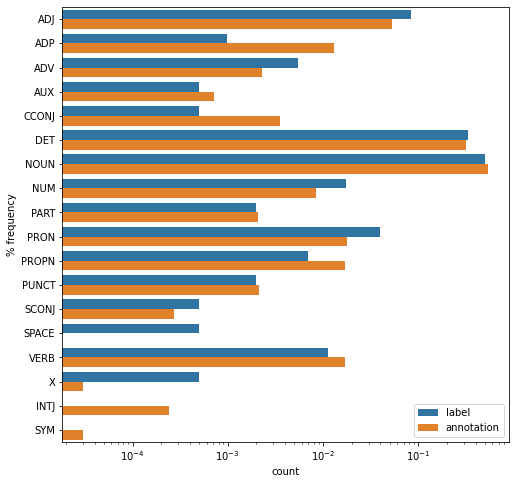

In [96]:
## plot combined
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
sns.barplot(x='count', y='POS', hue='data_type', data=combined_POS_counts)
plt.legend(loc='lower right')
plt.xscale('log')
plt.ylabel('% frequency')
plt.show()

What are the top words in each category?

In [106]:
## get POS/word counts
label_POS_word_counts = []
annotation_POS_word_counts = []
for data_i in annotated_data:
    label_POS_word_counts.extend([(x.text.lower(), x.pos_) for x in data_i['label_subtree']])
    for subtrees_j in data_i['annotation_subtrees']:
        for subtree_k in subtrees_j:
            if(type(subtree_k) is Span):
                annotation_POS_word_counts.extend([(x.text.lower(), x.pos_) for x in subtree_k])
## get aggregate counts!!
label_POS_word_counts = pd.DataFrame(label_POS_word_counts, columns=['word', 'POS'])
annotation_POS_word_counts = pd.DataFrame(annotation_POS_word_counts, columns=['word', 'POS'])
label_POS_word_counts = label_POS_word_counts.groupby('POS').apply(lambda x: x.loc[:, 'word'].value_counts()).reset_index(name='count').rename(columns={'level_1' : 'word'})
annotation_POS_word_counts = annotation_POS_word_counts.groupby('POS').apply(lambda x: x.loc[:, 'word'].value_counts()).reset_index(name='count').rename(columns={'level_1' : 'word'})

In [113]:
for POS_tag_i in combined_POS_counts.loc[:, 'POS'].unique():
    print(f'POS tag {POS_tag_i}')
    label_POS_word_counts_i = label_POS_word_counts[label_POS_word_counts.loc[:, 'POS']==POS_tag_i].sort_values('count', inplace=False, ascending=False).loc[:, ['word', 'count']]
    annotation_POS_word_counts_i = annotation_POS_word_counts[annotation_POS_word_counts.loc[:, 'POS']==POS_tag_i].sort_values('count', inplace=False, ascending=False).loc[:, ['word', 'count']]
    print('label word counts')
    display(label_POS_word_counts_i.head(10))
    print('annotation word counts')
    display(annotation_POS_word_counts_i.head(10))

POS tag ADJ
label word counts


,word,count
0,young,21
1,large,16
2,little,8
3,white,6
4,small,6
5,various,5
6,other,4
7,long,4
8,different,4
9,black,3


annotation word counts


,word,count
0,young,168
1,black,67
2,white,57
3,little,55
4,large,46
5,small,39
6,other,37
7,blue,31
8,older,28
9,red,28


POS tag ADP
label word counts


,word,count
89,out,1
90,up,1


annotation word counts


,word,count
456,of,264
457,in,69
458,with,29
459,on,21
460,up,12
461,for,9
462,from,5
463,down,5
464,out,3
465,above,3


POS tag ADV
label word counts


,word,count
91,very,4
92,backflip,1
93,ornately,1
94,well,1
95,curly,1
96,about,1
97,extremely,1
98,back,1


annotation word counts


,word,count
472,back,10
473,how,10
474,very,4
475,else,4
476,chalk,4
477,well,3
478,bong,3
479,really,2
480,backwards,2
481,shed,2


POS tag AUX
label word counts


,word,count
99,do,1


annotation word counts


,word,count
514,'s,7
515,are,4
516,is,3
517,do,2
518,was,2
519,be,2
520,did,1
521,had,1
522,have,1
523,has,1


POS tag CCONJ
label word counts


,word,count
100,and,1


annotation word counts


,word,count
524,and,113
525,both,2
526,or,2


POS tag DET
label word counts


,word,count
101,a,459
102,the,100
103,his,30
104,an,25
105,her,21
106,their,17
107,another,12
108,some,2
109,both,2
110,your,1


annotation word counts


,word,count
527,a,6718
528,the,2409
529,an,471
530,his,399
531,her,329
532,their,128
533,some,70
534,another,59
535,that,13
536,this,12


POS tag NOUN
label word counts


,word,count
113,man,59
114,person,30
115,woman,28
116,people,18
117,boy,18
118,girl,14
119,group,13
120,boys,11
121,baby,10
122,front,10


annotation word counts


,word,count
550,man,666
551,person,477
552,woman,315
553,people,231
554,girl,222
555,boy,218
556,guy,204
557,group,169
558,child,159
559,kids,131


POS tag NUM
label word counts


,word,count
634,two,24
635,three,7
636,one,2
637,four,1
638,nine,1


annotation word counts


,word,count
3428,two,175
3429,one,27
3430,2,26
3431,three,13
3432,four,8
3433,3,7
3434,1,4
3435,2000,4
3436,4,3
3439,five,2


POS tag PART
label word counts


,word,count
639,'s,4


annotation word counts


,word,count
3448,'s,47
3449,to,21
3450,n't,1


POS tag PRON
label word counts


,word,count
640,it,23
641,them,12
642,someone,10
643,he,10
644,they,5
645,she,4
646,himself,3
647,her,2
648,him,2
649,us,2


annotation word counts


,word,count
3451,someone,145
3452,it,82
3453,he,61
3454,them,56
3455,something,40
3456,she,30
3457,they,28
3458,himself,22
3459,him,22
3460,her,17


POS tag PROPN
label word counts


,word,count
655,teams,1
656,diagram,1
657,camo,1
658,triangular,1
659,christmas,1
660,hockey,1
661,young,1
662,miami,1
663,michael,1
664,yolk,1


annotation word counts


,word,count
3481,kid,15
3483,english,10
3482,lady,10
3484,christmas,9
3485,chef,9
3486,guy,8
3487,siblings,7
3488,yolk,7
3489,atm,6
3490,spanish,6


POS tag PUNCT
label word counts


,word,count
669,-,4


annotation word counts


,word,count
3823,-,59
3824,",",9
3825,',3


POS tag SCONJ
label word counts


,word,count
670,like,1


annotation word counts


,word,count
3826,while,8
3827,like,1


POS tag SPACE
label word counts


,word,count
671,,1


annotation word counts


,word,count


POS tag VERB
label word counts


,word,count
672,built,1
684,dirt,1
693,stretching,1
692,stuffed,1
691,making,1
690,riding,1
689,strung,1
688,building,1
687,shown,1
686,held,1


annotation word counts


,word,count
3829,wearing,26
3830,moving,9
3831,sitting,8
3833,playing,8
3832,made,8
3834,colored,7
3835,dancing,7
3836,pull,7
3837,cutting,7
3838,throwing,6


POS tag X
label word counts


,word,count
695,blacksmith,1


annotation word counts


,word,count
4140,2,1


POS tag INTJ
label word counts


,word,count


annotation word counts


,word,count
548,boy,6
549,man,2


POS tag SYM
label word counts


,word,count


annotation word counts


,word,count
3828,/,1


### POS tag sequences
Let's look at the relative frequency of different tag sequences in the labels and annotations.

In [141]:
from spacy.tokens.span import Span
def get_POS_sequence(subtree):
    return '_'.join([x.pos_ for x in subtree])
label_POS_sequences = [(x['label_subtree'], get_POS_sequence(x['label_subtree'])) for x in annotated_data if type(x['label_subtree']) is Span]
annotation_POS_sequences = [(z, get_POS_sequence(z)) for x in annotated_data for y in x['annotation_subtrees'] for z in y if type(z) is Span]
label_POS_sequences = pd.DataFrame(label_POS_sequences, columns=['word', 'POS_sequence'])
annotation_POS_sequences = pd.DataFrame(annotation_POS_sequences, columns=['word', 'POS_sequence'])
# fix words
label_POS_sequences = label_POS_sequences.assign(**{'word' : label_POS_sequences.loc[:, 'word'].apply(lambda x: x.text.lower())})
annotation_POS_sequences = annotation_POS_sequences.assign(**{'word' : annotation_POS_sequences.loc[:, 'word'].apply(lambda x: x.text.lower())})
# label_POS_sequences = label_POS_sequences[label_POS_sequences.loc[:, 'POS_sequence']!='']
# annotation_POS_sequences = annotation_POS_sequences[annotation_POS_sequences.loc[:, 'POS_sequence']!='']
## get aggregate counts
label_POS_sequence_counts = label_POS_sequences.loc[:, 'POS_sequence'].value_counts()
annotation_POS_sequence_counts = annotation_POS_sequences.loc[:, 'POS_sequence'].value_counts()
# normalize
label_POS_sequence_counts = label_POS_sequence_counts / label_POS_sequence_counts.sum()
annotation_POS_sequence_counts = annotation_POS_sequence_counts / annotation_POS_sequence_counts.sum()

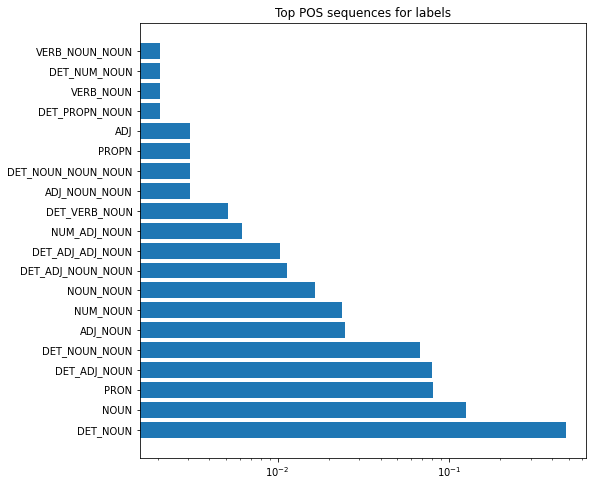

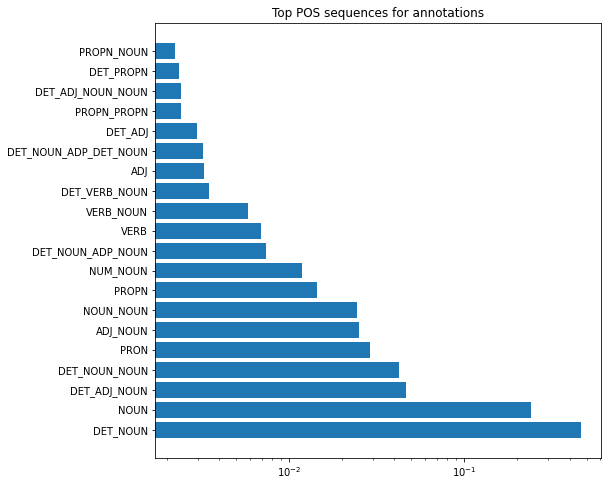

In [142]:
## plot counts
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
top_k = 20
# label POS sequences
plt.figure(figsize=(8,8))
plt.barh(label_POS_sequence_counts.index[:top_k], label_POS_sequence_counts[:top_k])
plt.xscale('log')
plt.title('Top POS sequences for labels')
plt.show()
# annotation POS sequences
plt.figure(figsize=(8,8))
plt.barh(annotation_POS_sequence_counts.index[:top_k], annotation_POS_sequence_counts[:top_k])
plt.xscale('log')
plt.title('Top POS sequences for annotations')
plt.show()

Fewer pronouns for annotations than for labels. Similar levels of adjectives.

In [145]:
## most frequent words for different sequences
top_k = 10
for POS_sequence_i in label_POS_sequence_counts.index[:top_k]:
    print(f'testing POS sequence {POS_sequence_i}')
    label_POS_sequences_i = label_POS_sequences[label_POS_sequences.loc[:, 'POS_sequence']==POS_sequence_i]
    annotation_POS_sequences_i = annotation_POS_sequences[annotation_POS_sequences.loc[:, 'POS_sequence']==POS_sequence_i]
    ## get counts
    label_word_counts_i = label_POS_sequences_i.loc[:, 'word'].value_counts()
    annotation_word_counts_i = annotation_POS_sequences_i.loc[:, 'word'].value_counts()
    # normalize
    label_word_counts_i = label_word_counts_i / label_word_counts_i.sum()
    annotation_word_counts_i = annotation_word_counts_i / annotation_word_counts_i.sum()
    print(f'label word counts\n{label_word_counts_i.head(10)}')
    print(f'annotation word counts\n{annotation_word_counts_i.head(10)}')

testing POS sequence DET_NOUN
label word counts
a man        0.096360
a person     0.057816
a woman      0.044968
a group      0.021413
a boy        0.017131
a piece      0.014989
a girl       0.012848
the water    0.010707
a child      0.010707
a guy        0.008565
Name: word, dtype: float64
annotation word counts
a person    0.048089
a man       0.046363
a woman     0.022318
a guy       0.019975
a girl      0.013933
a group     0.013317
a boy       0.013194
a child     0.011961
a lady      0.011467
a kid       0.010851
Name: word, dtype: float64
testing POS sequence NOUN
label word counts
people      0.105691
front       0.081301
men         0.032520
music       0.032520
kids        0.016260
dogs        0.016260
metal       0.016260
material    0.016260
others      0.016260
cards       0.016260
Name: word, dtype: float64
annotation word counts
people      0.036571
kids        0.016148
man         0.015673
music       0.014486
boys        0.011874
men         0.011399
children    0.0

- `PRON`: Annotations tend to use more specific pronoun phrases like `someone` or `something` rather than `it`.
- `DET_NOUN`: annotations are less gender-biased? Prefer `person` over `man`.